# Exploratory Data Analysis of Cancer Genomics data using TCGA

In this notebook, we will take a look at one of the canonical datasets, if not _the_ dataset, in cancer genomics: TCGA.

We'll start with investigating the RNA Sequencing (rnaseq) and Clinical data available for a type of liver cancer known as hepatocellular carcinoma (HCC). Hepatocellular carcinoma is the most common form of liver cancer in the United States, making up [more than 80% of cases](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/liver). The TCGA dataset is abbreviated LIHC.

Some examples of what researchers have learned from the LIHC dataset at the DNA-level include confirmed [frequent mutations](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/liver) in:
 - The TERT promotor region, associated with regulating cell survival
 - TP53, one of the most frequently mutated genes in cancer
 - CTNNB1, a member of the Wnt signaling pathway that mediates cell growth and differentiation
     
There are currently several therapies under development that target these genes.

In addition to DNA alterations however, different biological and tumor microenvrionment factors can [influence disease progression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6237857/). A transcriptomic survey of tissues at various stages of disease progression could help elucidate some of the underlying pathways contributing to tumorigenesis.   

### Today, we'll be focusing on using RNA-seq data from LIHC combined with clinical attributes to identify biomarkers for disease progression. 
 
The data is stored in the R package _[RTCGA](http://rtcga.github.io/RTCGA/)_

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Set variables

In [2]:
data_dir=""
response_name="patient.race"
rnaseq_file=data_dir+"lihc_rnaseq.csv.gz"
clinical_file=data_dir+"lihc_clinical.csv.gz"

## Load data

The data is stored in the RTCGA package in the R programming language. I've outputted it for easy use within python. 

We will be investigating the Hepatocellular carcinoma dataset. Read about it [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5680778/).

The TCGA RNASeq data is illumina hiseq Level 3 RSEM normalized expression data. You can read about thec RSEM method [here](https://academic.oup.com/bioinformatics/article/26/4/493/243395).

Essentially this is the raw counts of reads that aligned to the gene transcript, though it's only a guess by the program. Since it's a guess, the values are rational numbers. To simplify things, we'll round the values to the next whole integer. 



In [3]:
rnaseq = (pd.
          read_csv(rnaseq_file,compression="gzip").
          set_index('bcr_patient_barcode').
          applymap(lambda x : int(np.ceil(x)))
         )
display(rnaseq.shape)
display(rnaseq.head())

(423, 20531)

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,0,2,4,91,1018,0,142,1,0,0,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,0,27,3,72,640,0,123,2,0,0,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,0,0,5,96,743,0,96,2,1,0,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,0,6,6,62,1187,0,281,1,0,0,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,0,12,6,105,879,0,283,0,0,0,...,42,1000,1632,5,1381,2903,576,666,3,120


In [4]:
gene_name_logical = [len(x[0])>1 for x in rnaseq.columns.str.split('|')]
sub = rnaseq.loc[:,gene_name_logical]
sub.columns = [x[0] for x in sub.columns.str.split('|')]
rnaseq_sub = sub.copy()
rnaseq_sub.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,22283,584,0,375,0,286320,81,543,1,1032,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,22642,1573,3,99,0,31169,163,2,1,903,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,77670,1281,0,215,1,19515,119,1,3,773,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,9323,1253,0,2914,2,243941,72,0,0,722,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,84243,1641,0,404,0,8756,83,0,9,828,...,42,1000,1632,5,1381,2903,576,666,3,120


The clinical data is within the RTCGA package, but is also available [here](https://portal.gdc.cancer.gov/projects/TCGA-LIHC). More cdescription of the clinical attributes are [here](https://gdc.cancer.gov/about-data/data-harmonization-and-generation/clinical-data-harmonization).

In [5]:
clinical = pd.read_csv(clinical_file,compression="gzip").set_index('patient.bcr_patient_barcode')
display(clinical.shape)
display(clinical.head())

(377, 1586)

,admin.bcr,admin.day_of_dcc_upload,admin.disease_code,admin.file_uuid,admin.month_of_dcc_upload,admin.patient_withdrawal.withdrawn,admin.project_code,admin.year_of_dcc_upload,patient.ablation_embolization_tx_adjuvant,patient.additional_studies,...,patient.samples.sample.preservation_method,patient.samples.sample.sample_type,patient.samples.sample.sample_type_id,patient.samples.sample.shortest_dimension,patient.samples.sample.time_between_clamping_and_freezing,patient.samples.sample.time_between_excision_and_freezing,patient.samples.sample.tissue_type,patient.samples.sample.tumor_descriptor,patient.samples.sample.tumor_pathology,patient.samples.sample.vial_number
patient.bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s,nationwide children's hospital,1,lihc,47a9da83-f87b-45a0-a501-542c5a9df212,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gs,nationwide children's hospital,1,lihc,ada84bc2-9724-428c-9557-7280af5f8297,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gt,nationwide children's hospital,1,lihc,b9f63d47-2293-4360-b373-5acdaa2ec7cb,10,False,tcga,2015,NaN,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gu,nationwide children's hospital,1,lihc,2b488ba2-f46b-4d0b-8c73-d9a761ab61b1,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gv,nationwide children's hospital,1,lihc,69fc70f4-fe6a-472a-b354-cf37515c524d,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a


## Gene level distribution

In this section, we will investigate the value distribution of genes in our dataset.

<br>

#### Sample Questions:

- What is the range of values for a given gene?

- What is the distribution of values for a given gene?

- Are there higher than average or lower than average expression of genes?

In [11]:
# Range
max(rnaseq_sub['A2M']), min(rnaseq_sub['A2M'])

(636516, 1726)

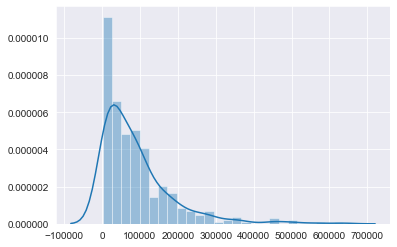

In [12]:
# Distribution
sns.set_style('darkgrid')
sns.distplot(rnaseq_sub['A2M'].values)

In [14]:
rnaseq_sub.describe()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,...,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,50231.567376,1698.881797,0.990544,299.981087,0.869976,88954.721040,179.319149,12.416076,4.898345,897.635934,...,31.174941,634.659574,973.817967,45.593381,1006.560284,3783.862884,699.167849,576.059102,9.049645,94.184397
std,49856.735087,858.645373,11.855365,286.785948,2.651946,93914.773995,204.444038,66.469798,15.659940,265.338262,...,15.873243,461.145316,264.967274,51.522508,505.714787,2093.308562,310.587919,226.443655,26.050805,96.808205
min,27.000000,0.000000,0.000000,8.000000,0.000000,1726.000000,13.000000,0.000000,0.000000,397.000000,...,0.000000,20.000000,217.000000,0.000000,85.000000,300.000000,168.000000,164.000000,0.000000,0.000000
25%,16013.000000,1116.500000,0.000000,157.000000,0.000000,22638.500000,68.000000,0.000000,0.000000,714.500000,...,20.000000,332.500000,791.000000,9.000000,627.000000,2325.500000,477.500000,423.500000,2.000000,11.500000
50%,40262.000000,1588.000000,0.000000,239.000000,0.000000,65570.000000,114.000000,1.000000,0.000000,852.000000,...,30.000000,523.000000,942.000000,30.000000,896.000000,3512.000000,617.000000,543.000000,4.000000,77.000000
75%,75207.000000,2157.000000,0.000000,354.500000,0.000000,117118.500000,185.000000,3.000000,3.000000,1039.000000,...,40.500000,813.500000,1127.500000,62.000000,1269.500000,4760.500000,866.500000,698.000000,8.000000,139.000000
max,542016.000000,4612.000000,239.000000,2914.000000,23.000000,636516.000000,1859.000000,793.000000,245.000000,2487.000000,...,130.000000,4483.000000,2064.000000,406.000000,2813.000000,15605.000000,1823.000000,2094.000000,351.000000,694.000000


In [19]:
# Genes with expression less than or greater than 2 std from mean
avg_expression_all_genes = rnaseq_sub.mean().mean()



1488.0300036105025

## Dimension reduction based on gene expression

If we were working for a smaller dataset we'd be able to plot the few genes we had on a expression by sample graph. However, we are working with 20k genes and will need a better method than creating 20k separate plots. One way to visualize sample distances is to reduce the dimensional space of gene expression across samples.

Using principal component analysis (PCA) we can project the data points into a 2D plane so that each axis or component captures the greatest variation of the sample expression. 

PCA can be useful to characterize the distances between samples and identify groups of samplings that may be farther or closer apart. We can also identify any samples that might be worth excluding from our analysis. Documentation on sklearn's PCA function can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=2)

## Differential Expression Analysis

We can statistically test for a difference in gene expression by performing a hypothesis test for each gene to see whether there is evidence to decide that expression is signficantly different between conditions. 
In this section, we will investigate differential expression results derived from the [DESeq2] package in R. Also see this [vignette](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) on how to do these analyses, as well as understand the methods. 

Briefly, a Sample x Gene matrix of raw count reads and a matching matrix of phenotypes (eg, treatment or condition) for each sample are inputted into DEseq2. In order to account for RNA composition bias and library size, when only a small number of genes are highly expressed in one condition vs another, these genes are normalized by diving the expression by the mean expression for each gene across samples. 

DEseq2 fits a [negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) generalized linear model to each gene and uses the [Wald test](https://www.statisticshowto.datasciencecentral.com/wald-test) for significance. Outliers are detected using Cooke's distance and removed from the dataset. Genes with low normalized mean expression values below a threshbold are also removed to improve detection power. https://chipster.csc.fi/manual/deseq2.html

#### Sample questions:
- Which genes are differentially expressed? Are they positively or negatively expressed compared to your control?
- What do these genes do? Which pathways are they involved in?
- Are there related clinical phenotypes which might show similar differences in expression?

### Running differential expression analysis via DEseq2
We've created a subprocess to run the R package DEseq2 with our data and return the results in a python-friendly format. 

To run this script on the command line use:
```
Rscript TCGA_differential_expression_analysis.R "" lihc_rnaseq.csv.gz lihc_clinical.csv.gz 100 patient.gender female male
```

(script name | rna_seq_file.csv.gz | clinical_data_file.csv.gz | num_genes_to_run | clinical_attribute_col | atttribute 1 | attribute 2

Use the output of this file (lihc_DESeq2_100_sampled_genes_patient.gender_female_vs_male.csv) to plot and identify differentially-expressed genes. You can change the clinical columns, attributes and number of genes to explore additional clinical variables.

In [8]:
de_gender = pd.read_csv('lihc_DESeq2_100_sampled_genes_patient.gender_female_vs_male.csv')
de_gender.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene
0,0.386931,-0.460346,0.498665,-0.923158,3.559248e-01,5.813439e-01,TRPV5
1,0.022940,-0.073650,2.238344,-0.032904,9.737514e-01,9.994934e-01,KRTAP10.7
2,13.638057,1.692997,0.210093,8.058310,7.735626e-16,7.580913e-14,ATP6V1B1
3,175.257291,0.090832,0.129924,0.699115,4.844801e-01,6.718166e-01,SARM1
4,235.103073,0.004816,0.151323,0.031824,9.746128e-01,9.994934e-01,KCNMA1


Create a diagnostic plots to help us visualize the data. An MA-plot shows the log2 fold changes from the treatment over the mean of normalized counts, i.e. the average of counts normalized by size factor. 

### Pathway analysis
We can do a brief survey of what kinds of pathways and functions some of our differentially expressed genes are involved in. Using the [BioMart](http://www.biomart.org/martservice_9.html) service to annotate our genes with gene ontology (GO) terms.

In [11]:
from pybiomart import Server, Dataset

In [12]:
dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

attributes = [
    'go_id',
    'name_1006',
    'definition_1006',
    'hgnc_symbol',
]

bm = dataset.query(attributes=attributes,
              filters={'chromosome_name': ['1','2']})

bm

,GO term accession,GO term name,GO term definition,HGNC symbol
0,NaN,NaN,NaN,RNA5SP65
1,NaN,NaN,NaN,RN7SKP195
2,NaN,NaN,NaN,RNU7-29P
3,NaN,NaN,NaN,SNORA77
4,NaN,NaN,NaN,MIR4425
...,...,...,...,...
63320,GO:0030182,neuron differentiation,The process in which a relatively unspecialize...,NIF3L1
63321,GO:1903507,negative regulation of nucleic acid-templated ...,"Any process that stops, prevents or reduces th...",NIF3L1
63322,GO:0005739,mitochondrion,"A semiautonomous, self replicating organelle t...",NIF3L1
63323,GO:0042802,identical protein binding,Interacting selectively and non-covalently wit...,NIF3L1


## Clinical data type investigation

Now that we've gone through the steps of exploratory analysis for a single clinical attribute, you can repeat this process and explore how other clinical factors may change gene expression. In this section, we will investigate the diversity of the clinical data. Explore the clinical attributes available in the dataset. 

We are interested in understanding whether there are RNA signatures that are change according to disease progression for hepatocellular carcinoma. Are there any relevant attributes in the clinical data which are relevant to identifying this find of biomarker? 


#### Sample Questions:

- How many unique values are there for a given clinical attribute?

- How can we define an appropriate response variable for supervised learning?
 
- What clinical attributes can be used to identify biomarkers for disease progression?

## Set up for supervised learning 

In this section, we will set up a supervised learning paradigm using the Genes within the RNASeq data as predictors and a clinical attribute as a response variable. 